In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

# set pandas to display all rows for inspection
pd.set_option('display.max_rows', None)

/tmp/ipykernel_1850/3326899178.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [10]:
# import jsons of capital pool, ramm volume and covers from dune api 
dune = DuneClient(key)
cap_pool_result = dune.get_latest_result_dataframe(1442422)
ramm_volume_result = dune.get_latest_result_dataframe(3219988)
covers_list_result = dune.get_latest_result_dataframe(2303588)

In [3]:
# manually input kiln rewards
kiln_rewards = 162.1547

In [13]:
# process capital pool table

df_cap_raw = cap_pool_result

# drop moving average columns
df_cap = df_cap_raw.drop(columns=['moving_average_eth', 'moving_average_dai', 'running_total_display_curr'])
# rename columns
df_cap.rename(columns={'running_net_eth_display_curr': 'ETH',
                   'running_net_dai_display_curr': 'DAI',
                   'running_net_rpl_display_curr': 'rETH',
                   'running_net_lido_display_curr': 'stETH',
                   'running_net_enzyme_display_curr': 'Enzyme',
                  }, inplace=True)


# turn <nil> values into 0 for rETH and turn into floats
df_cap['rETH'] = df_cap['rETH'].replace('<nil>', '0').astype('float')
# change day to a datetime
df_cap['day'] = pd.to_datetime(df_cap['day'])

# Adjust Enzyme for Kiln returns

    # create datetime object of 2023/08/30 when the Kiln validators were activated 
kiln_deposit_date = datetime(year=2023, month=8, day=30, tzinfo=timezone.utc)

    # work out days since kiln deposit from the latest day and work out the rewards per day
days_since_kiln = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_kiln_rewards = kiln_rewards/days_since_kiln

    # create a column for kiln rewards based on the daily values since validators went live
df_cap['kiln_rewards'] = daily_kiln_rewards * (df_cap['day'] - kiln_deposit_date) / timedelta(days=1)
df_cap.loc[df_cap['kiln_rewards'] < 0, 'kiln_rewards'] = 0

    # Add Kiln rewards to Enzyme column and then drop the Kiln rewards column
df_cap['Enzyme'] = df_cap['Enzyme'] + df_cap['kiln_rewards']
df_cap.drop(columns=['kiln_rewards'], inplace=True)

# add all the columns except day together to get numeric total
df_cap['sum'] = df_cap.drop(columns=['day']).sum(axis=1)

In [14]:
df_cap

,day,ETH,DAI,rETH,stETH,Enzyme,sum
0,2024-03-27 00:00:00+00:00,29688.267918,1422.500352,14725.320757,33428.161845,13306.604533,92570.855406
1,2024-03-26 00:00:00+00:00,29739.508180,1440.543407,14724.396596,33428.161845,13305.832368,92638.442396
2,2024-03-25 00:00:00+00:00,29875.041016,1457.991778,14724.917149,33424.988964,13305.112435,92788.051342
3,2024-03-24 00:00:00+00:00,29973.473399,1450.435227,14726.291602,33422.092604,13304.392495,92876.685327
4,2024-03-23 00:00:00+00:00,30071.973706,1436.717775,14725.621824,33419.333031,13303.672591,92957.318928
5,2024-03-22 00:00:00+00:00,30173.279825,1418.364310,14723.976385,33416.271816,13302.952651,93034.844987
6,2024-03-21 00:00:00+00:00,30259.667453,1399.574926,14721.747554,33413.326691,13302.232719,93096.549342
7,2024-03-20 00:00:00+00:00,30347.937570,1376.635247,14720.538332,33410.195684,13301.512779,93156.819613
8,2024-03-19 00:00:00+00:00,30436.819210,1337.170630,14718.203163,33407.071931,13300.792847,93200.057781
9,2024-03-18 00:00:00+00:00,30561.712842,1302.880167,14715.648871,33403.455425,13300.072915,93283.770221


In [15]:
# ETH denominated monthly returns on individual investments

# stETH metrics in ETH
stETH_closing = df_cap.iloc[0]['stETH']
# monthly
stETH_monthly_opening = df_cap.iloc[30]['stETH']
stETH_monthly_return = stETH_closing - stETH_monthly_opening
# stETH monthly percentage
stETH_monthly_percentage = stETH_monthly_return / stETH_monthly_opening
# stETH annualised return last month
stETH_monthly_APY = ((1 + stETH_monthly_percentage) ** 12 - 1)
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%')

# rETH metrics in ETH
rETH_monthly_opening = df_cap.iloc[30]['rETH']
rETH_closing = df_cap.iloc[0]['rETH']
rETH_monthly_return = rETH_closing - rETH_monthly_opening
# rETH monthly percentage
rETH_monthly_percentage = rETH_monthly_return / rETH_monthly_opening
# rETH annualised return last month
rETH_monthly_APY = ((1 + rETH_monthly_percentage) ** 12 - 1)
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%')

## Enzyme
Enzyme_fee = 0.0015
# Enzyme overall metrics in ETH
Enzyme_monthly_opening = df_cap.iloc[30]['Enzyme']
Enzyme_closing = df_cap.iloc[0]['Enzyme']
Enzyme_monthly_return = Enzyme_closing - Enzyme_monthly_opening
# Enzyme monthly percentage
Enzyme_monthly_percentage = Enzyme_monthly_return / Enzyme_monthly_opening
# Enzyme annualised return last month
Enzyme_monthly_APY = ((1 + Enzyme_monthly_percentage) ** 12 - 1)
Enzyme_monthly_APY_after_fees = Enzyme_monthly_APY - Enzyme_fee
    
# Kiln standalone metrics in ETH
Enzyme_idle_portion = 6594 
Kiln_monthly_opening = Enzyme_monthly_opening - Enzyme_idle_portion
Kiln_closing = Enzyme_closing - Enzyme_idle_portion
Kiln_monthly_return = Kiln_closing - Kiln_monthly_opening
# Kiln monthly percentage
Kiln_monthly_percentage = Kiln_monthly_return / Kiln_monthly_opening
# Kiln annualised return last month
Kiln_monthly_APY = ((1 + Kiln_monthly_percentage) ** 12 - 1)
Kiln_monthly_APY_after_fees = Kiln_monthly_APY - Enzyme_fee

print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%')
print ('All returns after fees')

stETH Monthly APY: 3.381%
rETH Monthly APY: 3.761%
Enzyme Monthly APY: 1.823%; Kiln Portion Monthly APY: 3.803%
All returns after fees


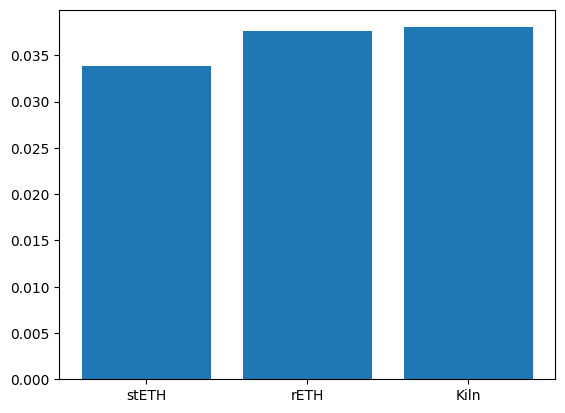

In [16]:
plt.bar(['stETH', 'rETH', 'Kiln'], [stETH_monthly_APY, rETH_monthly_APY, Kiln_monthly_APY_after_fees]);

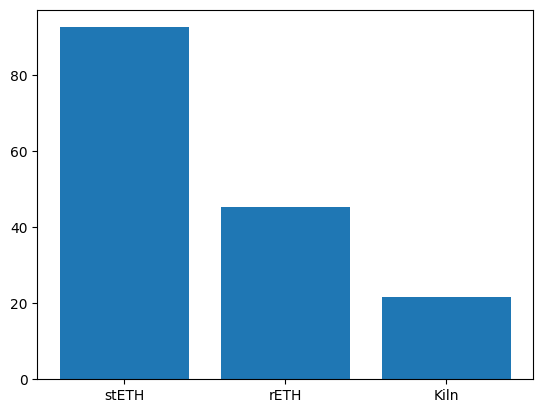

In [17]:
plt.bar(['stETH', 'rETH', 'Kiln'], [stETH_monthly_return, rETH_monthly_return, Kiln_monthly_return*(1-0.0015)]);

In [25]:
df_ramm = ramm_volume_result

# change timestamp to datetime format
df_ramm['ts'] = pd.to_datetime(df_ramm['ts'])

# group by date, take the latest value and re-sort into descending order
df_ramm = df_ramm.groupby(by=df_ramm['ts'].dt.date, as_index=False).first().\
            sort_values(['ts'], ascending=False).reset_index(drop=True)

ts                      object
cummulative_eth_in     float64
cummulative_eth_out    float64
cummulative_nxm_out    float64
cummulative_nxm_in     float64
dtype: object

In [53]:
ramm_flows_monthly_opening = df_ramm.iloc[30]['cummulative_eth_in'] - df_ramm.iloc[30]['cummulative_eth_out']
ramm_flows_monthly_closing = df_ramm.iloc[0]['cummulative_eth_in'] - df_ramm.iloc[0]['cummulative_eth_out']

ramm_flow_monthly_change = ramm_flows_monthly_closing - ramm_flows_monthly_opening
ramm_flow_monthly_change

-3060.7273047050912

In [54]:
# get net monthly change from DAI
dai_monthly_opening = df_cap.iloc[30]['DAI']
dai_monthly_closing = df_cap.iloc[0]['DAI']
dai_change = dai_monthly_closing - dai_monthly_opening

dai_change

-197.63223769626984

In [20]:
# opening total ETH value of capital pool
total_cap_monthly_opening = df_cap.iloc[30]['sum']
total_cap_monthly_closing = df_cap.iloc[0]['sum']

total_cap_monthly_opening

95653.37329348111

In [22]:
total_cap_monthly_closing

92570.85540556216

In [24]:
dai_change

-197.63223769626984